In [2]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
import pygame

pygame 2.6.1 (SDL 2.28.4, Python 3.11.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
def f (d, v_max, model = "log"):
    if model == "log":
        return v_max * np.log(d)
    else: # lin
        return v_max * (1 - 1/d)
    
def simulate(x_0, v_max, L, T, dt, model = "lin"):
    N = len(x_0) # Number of initial values == number of vehicles in traffic
    steps = int(T/dt) # ges Zeit durch time steps

    x = np.zeros((steps, N)) # initialize array to store each time step N for each position of x
    x[0]=x_0.copy() # initial conditions einlesen
    
    for k in range(steps-1):
        dx = np.zeros(N) # momente initialisieren

        dx[-1] = v_max # Maximales moment ist bekannt

        for i in range(N-1):
            d = abs(x[k, i+1] - x[k, i])/L # Abstand zum nächsten fahrzeug
            dx[i] = f(d, v_max, model)
        
        x[k+1] = x[k] + dt * dx

    return x

def single_step(x, v_max, L, dt, model):
    N = len(x) # Number of initial values == number of vehicles in traffic
    dx = np.zeros(N) # momente initialisieren
    for i in range(N-1):
            d = abs(x[i+1] - x[i])/L # Abstand zum nächsten fahrzeug
            dx[i] = f(d, v_max, model)
        
    return x + dt * dx, dx


x0 = np.array([0.0, 5.0, 12.0, 20.0])  # 4 Fahrzeuge
result = simulate(x0, v_max=30, L=4.5, T=20, dt=0.01, model="lin")

In [7]:
def simulation_screen(x0, v_max, L, dt, model):
    pygame.init()
    W, H = 1000, 200
    screen = pygame.display.set_mode((W, H))
    clock = pygame.time.Clock()
    scale = 5     # skaliert Meter → Pixel
    running = True
    x = np.array(x0, dtype=float)
    while running:
        clock.tick(60) # 60 FPS
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False             # Stop when closed
        
        x, v = single_step(x, v_max, L, dt, model)

        screen.fill((30, 30, 30))

        for i in range(len(x)):
            px = int(x[i]*scale)% W # start again from the beginning of the screen if done with the lap
            py = H/2 # bewegt sich auf der hälfter der screen höhe

            pygame.draw.circle(screen, (100, 200, 255), (px, py), 8) #cars

            vx = int(v[i] *0.4) # 0.4 skarilerungs faktor für weniger clutter
            pygame.draw.line(screen, (255, 160, 60), (py, py), (px+vx, py), 3)  #geschwindigkeits indikator linie

        pygame.display.flip()
    pygame.quit()

x0 = [0, 8, 18, 30]       # Startpositionen
simulation_screen(x0, v_max=30, L=4.5, dt=0.05, model="log")

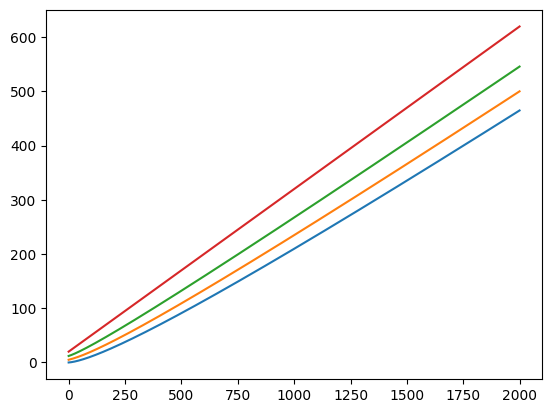

In [9]:
plt.plot(result)

In [8]:
import pygame
import numpy as np

# ---------- Dynamik-Modelle ----------
def f_lin(d, vmax):
    return vmax * (1 - 1/d)

def f_log(d, vmax):
    return vmax * np.log(d)


# ---------- Simulation ----------
def step_euler(x, vmax, L, dt, model):
    N = len(x)
    dx = np.zeros(N)

    # Leader
    dx[-1] = vmax

    # Followers
    for i in range(N - 1):
        d = abs(x[i+1] - x[i]) / L
        if d <= 0:
            d = 0.001
        if model == "lin":
            dx[i] = f_lin(d, vmax)
        else:
            dx[i] = f_log(d, vmax)

    return x + dt * dx, dx


# ---------- Visualisierung (Pygame) ----------
def run_simulation(x0, vmax=30, L=4.5, dt=0.05, model="lin"):
    pygame.init()
    W, H = 1000, 200
    screen = pygame.display.set_mode((W, H))
    clock = pygame.time.Clock()

    x = np.array(x0, dtype=float)
    scale = 5     # skaliert Meter → Pixel

    running = True
    while running:
        clock.tick(60)  # FPS
        
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # Berechne Dynamik
        x, v = step_euler(x, vmax, L, dt, model)

        # Zeichnen
        screen.fill((30, 30, 30))

        for i in range(len(x)):
            px = int(x[i] * scale) % W    # wrap-around
            py = H // 2

            # Auto
            pygame.draw.circle(screen, (100, 200, 255), (px, py), 8)

            # Geschwindigkeitspfeil
            vx = int(v[i] * 0.4)     # skaliert für Anzeige
            pygame.draw.line(screen, (255, 160, 60), (px, py), (px + vx, py), 3)

        pygame.display.flip()

    pygame.quit()


# ------------ START ------------
x0 = [0, 8, 18, 30]       # Startpositionen
run_simulation(x0, model="lin")
